# **Data Cleaning**

### Hey everyone, 
I wanted to practice some data cleaning steps. I tried to explain everything as detailed as necessary and I hope that this notebook helps you at least a little bit. Feel free to suggest any improvements.

We will focus on the famous wine-reviews dataset. It contains information about both, the wine and the taster. 

**Note:** The following Data Cleaning methods have to be performed on both, train and test data. One **robust and error-resistent way of preprocessing both data sets** is using sklearn Pipelines. Feel free to take a look at my [Pipelining Notebook on kaggle](https://www.kaggle.com/milankalkenings/no-pipelines-you-are-probably-doing-it-wrong).

***
# **Topics:**
## 0. [**What is Data Cleaning?**](#sec0)
## 1. [**Find and visualize Missing Values**](#sec1)
## 2. [**Handle Missing Values**](#sec2)
#### 2.1. [Drop rows](#sec3)
#### 2.2. [Drop columns](#sec4)
#### 2.3. [Replace Null values with 'Unknown' or 0](#sec5)
#### 2.4. [Replace missing values with predicted values](#sec6)
## 3. [**Detect Measuring Errors**](#sec7)
#### 3.1. [Detect Measurng Errors using Outlier Detection](#sec8)
## 4. [**Change Measuring Units**](#sec8)
***

<a id="sec1"></a>
# 0. What is Data Cleaning?
Data Cleaning is the collective term for all methods which improve the [quality of data](https://en.wikipedia.org/wiki/Data_cleansing#Data_quality).
The Data Quality has huge impacts on the strenght of machine learning models, and thus we should definitely make sure to have profound knowledge about the various tools of Data Cleaning.

High quality data has the following properties:

### Completeness:
* There should be no [missing values](#sec1) in our dataset.

### Consistency:
* There should be no inconsistencies whithin the data.
* Inconsistencies may occure in one dataset or between multiple dataset.
* Example 1: One data set contains the customers places of residence. An inconsistency would occure, when the zip code and the address don't match within the same row
* Example 2: One dataset contains information about the status of your companies cargo ships (damaged, under repair, scrapped). The second dataset contains information about the position of the cargo ships. An inconsistency would occure, when one cargo ship is said to be scrapped but on the open sea.

### Uniformity:
* The Measurements should be meaured on the same scale.
* Example 1: Some income might be measured in EUR, some might be measured in USD
* To improve the interpretability of our model, it might be helpful to asure uniformity even across multiple features (E.g. it might be helpful to measure both, the income and the expenses using the same unit)

### Accuracy:
* The data should be as close to the ground truth as possible
* Example: Since the exact height of people depends, among other things, on the daytime, it's impossible to determine 100% accurate measurements. Errors of a few millimeters are absolutely legit, but using absolutely inaccurate measurements (like 1.80 instead of 1.87) should be avoided.

### Validity:
* The data fulfills the nacessary constraints. These constraints could either be defined for functionality reasons (e.g. the uniqueness of identifiers), or for domain and business related reasons (e.g. the pattern of customer identifiers). I will not focus on this aspect, because the occuring tasks will be very versatile and it makes no sense to provide any *common* methods, since there are no.

Let us first of all load the dataset, import everything needed, and take a look at the top rows of this dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv('input/winemag-data-130k-v2.csv')
df.head(3)

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   

    designation  points  price           province           region_1  \
0  Vulkà Bianco      87    NaN  Sicily & Sardinia               Etna   
1      Avidagos      87   15.0              Douro                NaN   
2           NaN      87   14.0             Oregon  Willamette Valley   

            region_2    taster_name taster_twitter_handle  \
0                NaN  Kerin O’Keefe          @kerinokeefe   
1                NaN     Roger Voss            @vossroger   
2  Willamette Valley   Paul Gregutt           @paulgwine    

                                           title         variety  \
0              Nicosia 2013 Vulkà Bianco  (Etna)     White Blend   
1  Quinta dos Avidagos 2011 Avidagos Red (Douro)  Portuguese Red   
2  Rainstorm 2013 Pinot Gris (Willamette Valley)      Pinot Gris   

                winery  
0              Nicosia  
1  Quinta dos Avidagos  
2            Rainstorm

<a id="sec1"></a>
# 1. Find and visualize Missing Values
Missing values lead to a lack of [Completeness](#sec0), and thus we should definitely take care of them, even though there might be some models who can treat missing values. Why don't we just use models who can treat them? Simply because we don't want to renounce comparing as many models as possible.


It is not only important to know whether a dataset contains missing values, but also do we need to know which columns contain which amount of missing values. Missing values are blank spaces in our dataset that don't contain any values instead they contain any Null value like None or NaN.


Let's first of all determine how many Null values are contained in each column.



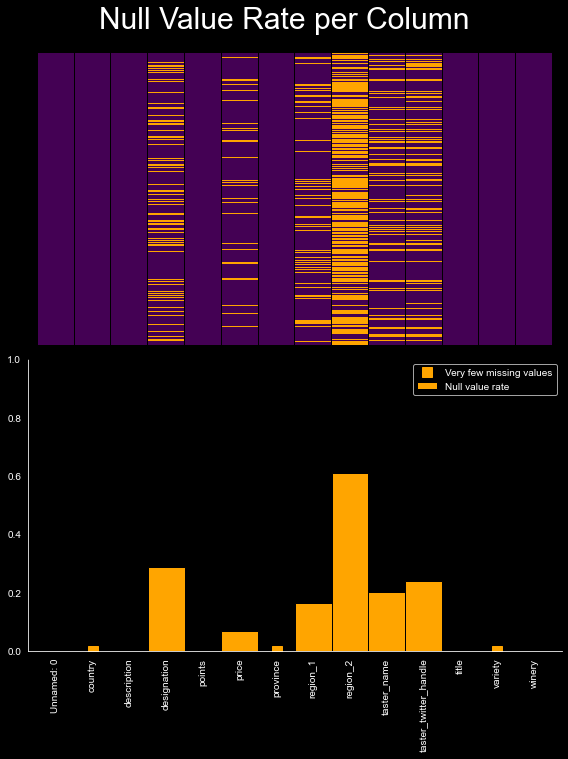

In [2]:
# NOTE: somehow, the heatmap of my dataset doesn't show the null value sin the columns 
# 'country', 'province' and 'variety'. Please help me to fix this.
def nullscan(df_check, save=False):
    '''
    df: a dataframe on which we want to perofrm the nullscan
    save: determines, whether you want to save the .png of the plot or not
    
    plots the rate of null values per column in a dataframe using 
    a seaborn heatmap and a barplot.
    '''    
    # a df with the same size of the original dataframe, containing True in cells containing NUll values.
    # and False in all the other cells.
    df_nulls = df_check.isna()
    # a series containing the sum of all values within a column having the column names as indices.
    # True is interpreted as 1 and False is interpreted as 0 
    nulls_per_col = df_nulls.sum(axis=0)
    # the rate makes it way more interpretable:
    nulls_per_col /= len(df_check.index)

    with plt.style.context('dark_background'):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 10))
    
        # ax1 is losely based on: https://www.kaggle.com/ipshitagh/wine-dataset-data-cleaning
        # NOTE: I could have used the cmap viridis or anything else instead, 
        # but I want to make clear that you can use any customized cmap as well.
        vir = matplotlib.cm.get_cmap('viridis')
        colormap = matplotlib.colors.ListedColormap([vir(0), 'orange'])
        sns.heatmap(df_check.isnull(), cmap=colormap, cbar=False, yticklabels=False, ax=ax1)
    
        nulls_per_col.plot(kind='bar', color='orange', x=nulls_per_col.values, 
                           y=nulls_per_col.index, ax=ax2, width=1, linewidth=1, 
                           edgecolor='black', align='edge', label='Null value rate')
        
        ax2.set_ylim((0,1))
        # centered labels
        labels=df_check.columns
        ticks = np.arange(0.5, len(labels))
        ax2.xaxis.set(ticks=ticks, ticklabels=labels)
    
        # hide spines:
        # NOTE: I could have used ax2.set_frameon(False), 
        # but I wanted the bottom and the left spine to stay white.
        ax2.spines['top'].set_color('black')
        ax2.spines['right'].set_color('black')
        
        
        
        # workaround to visualize very small amounts of null values per col
        na_ticks = ticks[(nulls_per_col > 0) & (nulls_per_col < 0.05)]
        if (len(na_ticks) > 0):
            ax2.plot(na_ticks, [0,]*len(na_ticks), 's', c='orange', markersize=10, 
                     label='Very few missing values')
    
        fig.suptitle('Null Value Rate per Column', fontsize=30, y=1.05)
        ax2.legend()
        fig.tight_layout() 
        if(save):
            plt.savefig('nullscan.png')
        plt.show()
nullscan(df)


As we can see, the dataset has some columns, which don't contain any missing values at all, some columns with a few missing values and some columns with quite a lot null values.

Now that we know, that the dataset contains missing values, we have to decide how to handle them.

<a id="sec2"></a>
# 2. Handle Missing Values

**There are some standard ways of handling these Null Values:**

* Drop rows containing a specified amount of Null Values. Use this method only, if the number of missing values within the respective row is very high and the missing values are relevant. 


* Drop columns containing a specified amount of Null Values if the column isn't too relevant and the number of missing values is very big.


* Replace missing values with the column average. The most common value of a categorical feature and the median or the mean of a numerical feature can be interpreted as the average of the respective column.


* Replace the missing value with a predicted value. Therefore, one could use KNN and replace the missing value with the most frequent value within the nearest neighbors.


* Replace the missing values with zeros or 'Unknown' and treat it just like any other value if possible

Besides these standard methods, further insights into the dataset and its context can reveal further suitable methods. For example if we have a dataset containing the email and the name of people, and the people column contains missing values and the email column only contains values in rows having null values in the name column, it might be useful to fill the emails into the corresponding name cells in order to obtain an identifier for each person containing the name or at least the email.

<a id="sec3"></a>
# 2.1. Drop rows

As we can see in the plot above, the columns 'country' and 'province' contain very few missing values. We could simply replace the missing values with 'Unknown', but since they contain such a small number of Null values, I want to show you how to drop the rows containing Null values in these columns. This method of handling Null values shouldn't be used too much, because we lose costly collected data. Hence, we should always consider if any other suitable methods could be applied instead if we are solving real-world problems.

I will apply this method for educational reasons.

In [3]:
# drop all rows with Null values in 'country', 'province' OR 'variety':
df = df.dropna(subset=['country', 'province', 'variety'])

# one could even drop all rows containing 'too many' Null values:
# nrows_before = len(df.index)
# na_allowed = int(len(df.columns)/3)
# thresh = int(len(df.columns)) - na_allowed
# df = df.dropna(axis=0, thresh=thresh)
# nrows_afterwards = len(df.index)
nullscan(df, save=True)

<a id="sec4"></a>
# 2.2. Drop Columns

Since the column 'region_2' contains many Null Values and isn't doesn't contain important information, we can simply drop the column.

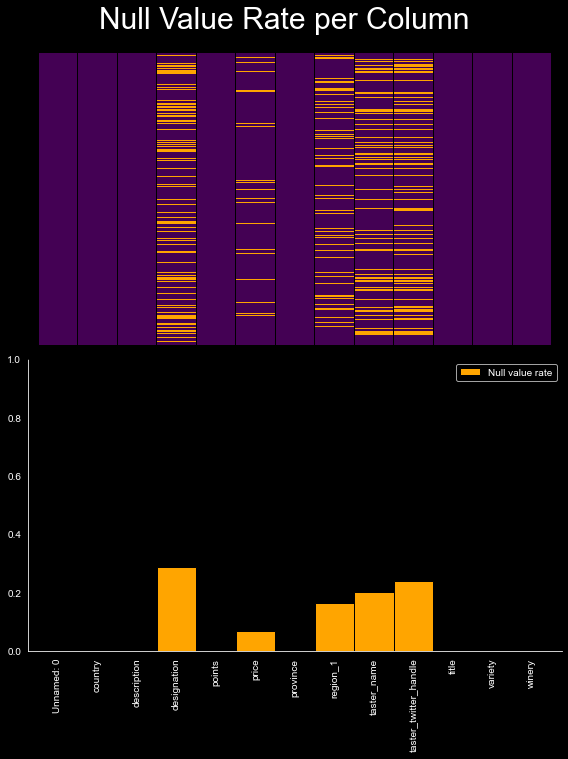

In [4]:
df = df.drop('region_2', axis=1)

nullscan(df)

<a id="sec5"></a>
# 2.3. Replace Null values with 'Unknown' or 0

The column 'designation' has the second biggest amount of Missing Values. Let's take a look at the column.

In [5]:
designation = df['designation'].value_counts().head(20) / len(df.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), sharey=True)
ax.barh(y=designation.index, width=designation.values, color='orange')
ax.set_title('Occurance of Designations in the Dataset', fontsize=20)
ax.set_xlabel('Occurance in the Dataset')
ax.set_ylabel('Designation')
ax.set_facecolor('black')

Some values appear pretty often and it might be interesting to reveal any relationships between this feature and the other features, e.g. the price or the points. Thus, we shouldn't drop the column but replace the missing values with anything suitable. Unfortunately, the most common designation 'Reserve' is merely occurring in slightly more than 1% of the rows. Hence, we shouldn't replace the missing values with this most common value of the column.

Alternatively, I suggest replacing missing values with 'Unknown' and treat it like any other value. The same method can be applied to the column 'region_1'.

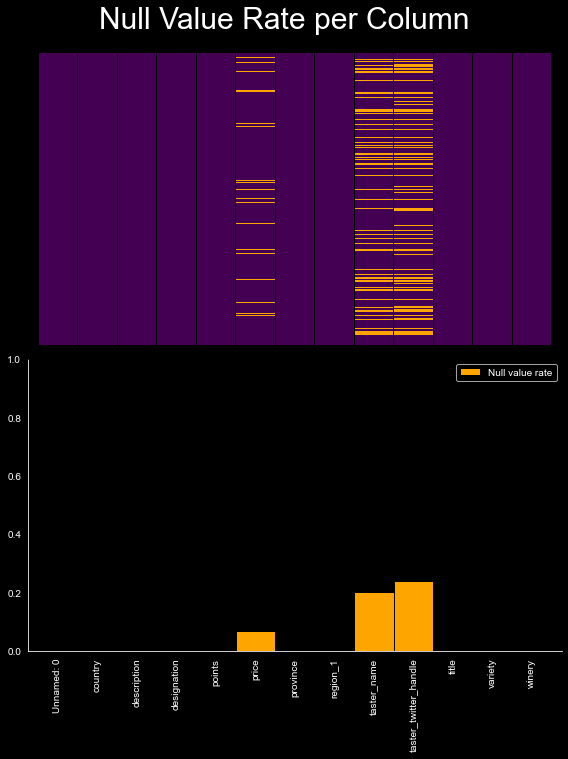

In [6]:
df[['designation', 'region_1']] = df[['designation', 'region_1']].fillna('Unknown')
nullscan(df)

To handle 'taster_name' and 'taster_twitter_handle', we have to get some insights into the data. 

We know that both represent a reviewer and it might happen, that some reviewers are solely known by their name, some others are solely known by their twitter handle. If so, we would have to find a way to merge these two columns into one column containing an identifier for the taster. To that end, we would prioritize the 'taster_name' to distinguish between the tasters from each other and fill the missing values in that column with the twitter handle in the respective rows. Furthermore, it might happen that a single twitter handle is used to review wines by multiple people or a single taster can have multiple twitter handles.

**Let's see how often a taster name is given but a twitter handle isn't:**

In [7]:
only_name = df.loc[df['taster_twitter_handle'].isnull() & df['taster_name'].notna(), 
                   ['taster_name', 'taster_twitter_handle']]
num_only_name = len(only_name.index)

only_twitter = df.loc[df['taster_name'].isnull() & df['taster_twitter_handle'].notna(), 
                      ['taster_name', 'taster_twitter_handle']]
num_only_twitter = len(only_twitter.index)

print(f'rows containing a name but no twitter handle: {num_only_name}'
      + f'\nrows containing a twitter handle but no taster name: {num_only_twitter}')

rows containing a name but no twitter handle: 4969
rows containing a twitter handle but no taster name: 0


Since it might happen, that tasters review wines using multiple twitter handles, and review differently using differing twitter handles (e.g. if they delete their twitter account and start reviewing wine on twitter using a new account), we should scan if there are any tasters using multiple twitter handles.

In [8]:
twitter_per_name = df.groupby('taster_name')['taster_twitter_handle'].nunique()

labels = twitter_per_name.index
#sizes = twitter_per_name

fig, ax = plt.subplots(figsize=(8,10))

twitter_per_name.plot(kind='barh', ax=ax, color='orange')
ax.set_xticks([0,1])
ax.set_xlabel('Number of Twitter Handles')
ax.set_ylabel('Taster')
ax.set_title('Twitter handles per taster', fontsize=20)
ax.set_facecolor('black')

As shown above, each taster uses either one Twitter Handle or no Twitter handle at all. Thus, we can simply drop the column 'taster_twitter_handle'. Moreover, we can replace the missing values in 'taster_name' with Unknown

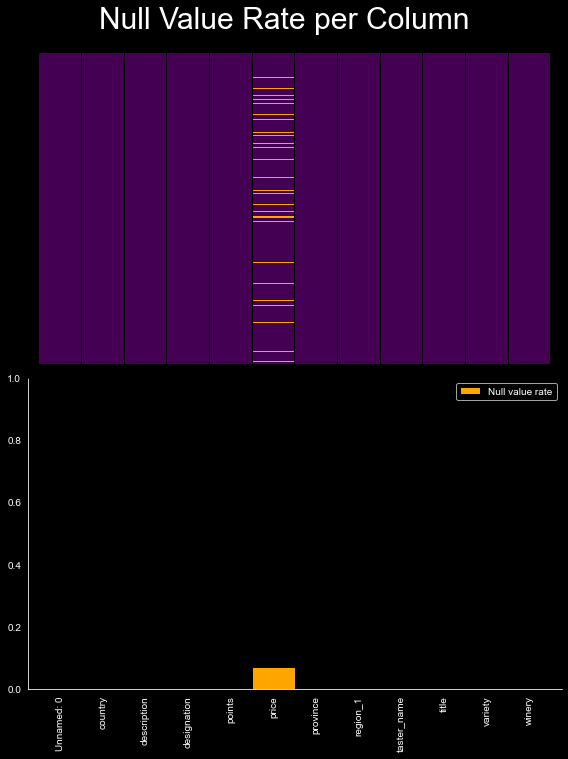

In [9]:
df = df.drop('taster_twitter_handle', axis=1)
df['taster_name'] = df['taster_name'].fillna('Unknown')
nullscan(df)

<a id="sec6"></a>
# 2.4. Replace missing values with predicted values

The last column containing Null values is 'price'. We could easily replace missing values with the column mean. The advantage of this method would be, that the column mean would stay the same, which might be important in later analysis steps. On the other hand, this method ( just like replacing missing values with the median of the column) is very unprecise and doesn't preserve the relationship between the respective feature and the other features.

I will give you a simple example of predicting the missing values using KNN. It will replace the missing price value with the median of the price values of the K nearest neighbors. Obviously, this method will most likely not reveal the real prices in all cases but will contain some residuals, but this method at least preserves the relationship between the used features. For simplicity, I will solely use the features 'points' and 'country' to predict the missing values.

Since we want to predict prices, i.e. numerical values, we use a regression model (KNeighboursRegressor). I will use the sklearn implementation and for simplicity reasons, I will not evaluate the number of neighbors used for the regression.

One advantage of using a KNN Regressor instead of any other regression model is that it (by definition) doesn't predict outliers. The sklearn KNeighboursRegressor predicts the mean of the y-values of the K nearest neighbors, but in some cases, it might be more suitable to predict the median. Unfortunately, predicting the mean is hardcoded in sklearns KNeighboursRegressor.

Firstly, convert the categorical columns 'country' and 'taster_name' to indicator variables and store the training data and the data on which we want to predict the prices individually.

In [10]:
df_cleanup = df.loc[:, ['price', 'points', 'country', 'taster_name']]
encoded = pd.get_dummies(df_cleanup[['country', 'taster_name']], prefix=['country', 'taster_name'])
df_cleanup = pd.concat([df_cleanup.drop(['country', 'taster_name'], axis=1), encoded], axis=1)

# training data
df_cleanup_known = df_cleanup.loc[df_cleanup['price'].notnull(), :]
X_known = df_cleanup_known.drop('price', axis=1)
y_known = df_cleanup_known['price']

# prediction data
df_cleanup_unknown = df_cleanup.loc[df_cleanup['price'].isnull(), :]
X_unknown = df_cleanup_unknown.drop('price', axis=1)

Let's create the Regressor.

In [11]:
knn_cleanup = KNeighborsRegressor(n_neighbors=10)
knn_cleanup.fit(X=X_known, y=y_known)

KNeighborsRegressor(n_neighbors=10)

Predict the prices and concatenate the data with already known prices and the data with predicted prices and shuffle the result in order to ensure that the rows with predicted prices are not stored in a huge block.

In [12]:
df_known = df.loc[df['price'].notnull(),:]
df_predicted = df.loc[df['price'].isnull(),:]
# to evade SettingWithCopyWarning
df_predicted = df_predicted.drop('price', axis=1)
df_predicted['price'] = knn_cleanup.predict(X_unknown)
df = pd.concat([df_known, df_predicted], axis=0, ignore_index=True)

# shuflle the dataset along rows
df = df.sample(frac=1).reset_index(drop=True)



nullscan(df)
df.head()

Unnamed: 0    country                                        description  \
0       81406     France  A soft, rounded, apples and cream style of win...   
1      125438  Australia  This Shiraz offers wonderful purity of fruit, ...   
2      117846         US  The 2010s are magical right now, and Norm Yost...   
3       27638         US  High toned, alcoholic nose, with cherry nail-p...   
4       43297      Chile  Campfire and hickory aromas dominate the nose ...   

                designation  points  price           province  \
0            Millesimé Brut      90   75.0          Champagne   
1                   Unknown      89   18.0  Western Australia   
2  Rio Vista Vineyard Dijon      94   46.0         California   
3           Special Reserve      87   10.0         California   
4          Victoria Reserve      84   12.0      Curicó Valley   

          region_1        taster_name  \
0        Champagne         Roger Voss   
1   Margaret River     Joe Czerwinski   
2  Sta. Rita Hills      Matt Kettmann   
3    Amador County       Paul Gregutt   
4          Unknown  Michael Schachner   

                                               title          variety  \
0   Laurent-Perrier 1999 Millesimé Brut  (Champagne)  Champagne Blend   
1                Xanadu 2007 Shiraz (Margaret River)           Shiraz   
2  Flying Goat Cellars 2010 Rio Vista Vineyard Di...       Pinot Noir   
3  Shenandoah 1998 Special Reserve Zinfandel (Ama...        Zinfandel   
4  San Nicolas 2011 Victoria Reserve Carmenère (C...        Carmenère   

                winery  
0      Laurent-Perrier  
1               Xanadu  
2  Flying Goat Cellars  
3           Shenandoah  
4          San Nicolas

<a id="sec7"></a>
# 3. Detect Measuring Errors
Measuring Errors have a huge impact on the [Data Quality](#sec0):
* Consistency: A measuring error might lead to contradictory values (as described in [Section 0](#sec0))
* Accuracy: For obvious reasons, measuring errors might lead to values far away from the ground truth

<a id="sec7"></a>
# 3.1. Detect Measurng Errors using Outlier Detection

Outliers can be found in all kinds of data, but I will focus on numerical data for the moment.
Outliers occur when the data has either high variance or when mistakes are made during the data collection (*measuring errors*)).

E.g. if we have a dataset of student grades and each student can achieve between 0 and 10 points and the dataset tells us that one student achieved more than 10 points, our dataset contains a measuring error and we have to determine how to handle this issue. In this case, the measuring error would be an outlier as well, and we could detect it via outlier detection. 

Nevertheless, there might be some more measuring errors within our dataset, which aren't outliers, but in most cases, there is no **simple** way to detect these and we have to deal with them and treat them as noise. 

Data-points which are both, measuring errors and outliers, might be very harmful and have a huge impact on our model. 
Besides handling these harmful measuring errors, handling outliers might help our model to be even more powerful and we may want to handle them during [Feature Engineering](https://www.kaggle.com/milankalkenings/comprehensive-tutorial-feature-engineering/edit/run/45767292).Hence, we should definitely detect the outliers for multiple reasons.

But how do we detect outliers automatically? 
And how do we decide if these outliers are harmful?
Let us find out whether the numerical column 'price' contains outliers.

The probably most famous ways of detecting outliers are using the *z score* and visualizing the data using a *boxplot*.

Text(0.5, 1.0, 'Outliers in Price?')

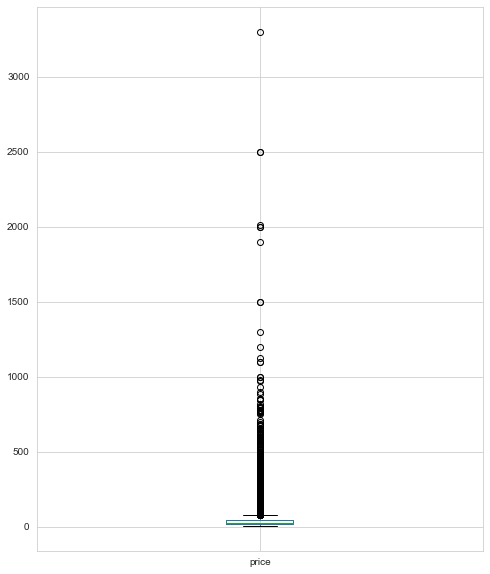

In [13]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 10))
df.boxplot(column='price', ax=ax1)
ax.set_title('Outliers in Price?')

As we can see, using a boxplot tells us that there are outliers in the respective column. Should we handle these as measuring errors?

This example shows us, that it isn't as easy to detect measuring errors as it is to detect missing values. One can simply determine if a value is missing or not, but we need further information to determine if a value is valid or not. 

I guess most of us wouldn't even think about buying a wine bottle that costs more than 200$, but every one of us knows that there are wines costing way more than a couple of hundred dollars per bottle, even though these wine bottles might not be found in the supermarket. Although expensive wines are rare, they still exist and thus we can't simply handle these data points as measuring errors. 

As you can see, boxplots (and z scores) might be useful, but in most cases, one needs to have some *domain knowledge* to determine whether one has to handle specific outliers separately as measuring errors or not. 

Anyways, if you are sure that you found some data-points which are measuring errors, you can treat them just like [Missing values](#sec1). 


<a id="sec8"></a>
# 4. Change Measuring Units
In order to obtain [Uniformity](#sec0), we might have to bring values to a differet unit. 

Unfortunately, it isn't always possible to determine, if one feature contains values, which were measured on the same scale. Further informations like notes from the data measuring process might be helpful. However, it might help to use a clustering algorithm to find out, if there are clusters with (context based) extremely dissimilar mean values.

Let me give you an easy example using [k-means clustering](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1):

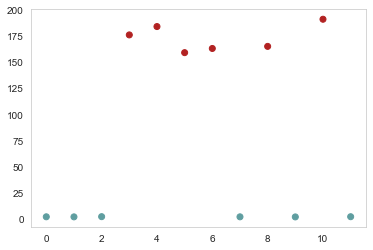

In [14]:
from sklearn.cluster import KMeans
height = np.array([1.74, 1.67, 1.87, 176, 184, 159, 163, 1.71, 165, 1.62, 191, 1.82])
np.size(height)

# use kmeans; try different number of clusters, if needed
cluster_kmeans = KMeans(n_clusters=2)
cluster_kmeans.fit(height.reshape((-1,1)))
# plot
colors = np.array(['cadetblue', 'firebrick'])
plt.scatter(x=range(np.size(height)), y=height, c=colors[cluster_kmeans.labels_])
plt.show()

Taking a look at the plotted clusters, it might be obvious, that the data isn't measured on the same scale. If it is obvious or not might depend on the context.
Afterwards, we can easily separate the clusters and bring them on the same scale:

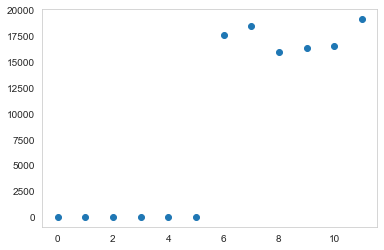

In [15]:
# separate the clusters
height_meter = height[cluster_kmeans.labels_ == 1]
height_cm = height[cluster_kmeans.labels_ == 0]
# bring them on a mutually equal scale
height_meter = height_meter * 100
# plot
height_transformed = np.append(height_cm, height_meter)
plt.scatter(x=range(np.size(height)), y=height_transformed)
plt.show()

In simple cases like this, it might even be sufficient to take a look at the variance, since the variance of this feature should is pretty big, which indicates the data to contain very versatile values. 

However, in most cases the best way to determine whether the data has differing scales within one feature is to refer to domain knowledge or notes from the data measuring procedure.

## That's it, thank you for reading my Notebook =)